In [2]:
import wandb
import numpy as np
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)


In [2]:
import os
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'


import catboost
import xgboost
os.environ.get("LD_LIBRARY_PATH")

'/eos/home-g/gkrzmanc/miniforge3/lib:/home/gkrzmanc/env/lib:'

In [22]:
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np
import torch
print("CUDA available:", torch.cuda.is_available())  # in case needed
 
DEVICE = torch.device("cuda:0")


def get_dataset():
    path = "/afs/cern.ch/work/g/gkrzmanc/mlpf_results/clustering_gt_with_pid_and_mean_features/cluster_features"
    r = {}
    n = 0
    #nmax = 257
    for file in os.listdir(path):
        #n += 1
        #if n > nmax:
        #    break
        f = pickle.load(open(os.path.join(path, file), "rb"))
        for key in f:
            if key not in r:
                r[key] = f[key]
            else:
                r[key] = torch.concatenate((r[key], f[key]), axis=0)
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg"]
    h1_names = ["hit_eta_avg", "hit_phi_avg"]
    print("x shape:", r["x"].shape)
    xyz = r["node_features_avg"][:, [0,1,2]].cpu()
    eta_phi = torch.stack([calculate_eta(xyz[:, 0], xyz[:, 1], xyz[:, 2]), calculate_phi(xyz[:, 0], xyz[:, 1])], dim=1)
    return torch.concatenate([r["x"], xyz, eta_phi], dim=1), x_names + h_names + h1_names, r["true_e_corr"], r["e_true"], r["e_reco"], r["y_particles"][:, 6]


def get_split(ds):
    from sklearn.model_selection import train_test_split
    x, _, y, etrue, _, pids = ds
    xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pid_train, pid_test = train_test_split(
        x, y, etrue, pids, test_size=0.2, random_state=42
    )
    return xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pid_train, pid_test

def get_gb():
    #from sklearn.ensemble import GradientBoostingRegressor
    #model = GradientBoostingRegressor(verbose=1, max_depth=7, n_estimators=1000)
    #model = catboost.CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=True, task_type="GPU", devices=DEVICE)
    #xgboost model
    model = xgboost.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.05, verbosity=1, tree_method="gpu_hist", gpu_id=DEVICE)
    return model

def calculate_phi(x, y):
    return np.arctan2(y, x)

def calculate_eta(x, y, z):
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)
    return -np.log(np.tan(theta/2))

def get_nn(patience):
    # pytorch impl. of a neural network
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.model = nn.ModuleList([
                nn.BatchNorm1d(13),
                nn.Linear(13, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, 1)]
            )
        def forward(self, x):
            for layer in self.model:
                x = layer(x)
            return x
        def freeze_batchnorm(self):
            for layer in self.model:
                if isinstance(layer, nn.BatchNorm1d):
                    layer.eval()
                    print("Frozen batchnorm in layer", layer)
        
    class NetWrapper():
        def __init__(self):
            pass
        def predict(self, x):
            x = torch.tensor(x).to(DEVICE)
            self.model.eval()
            with torch.no_grad():
                return self.model(x).cpu().numpy().flatten()
        def fit(self, x, y):
            x = torch.tensor(x).to(DEVICE)
            y = torch.tensor(y).to(DEVICE)
            self.model = Net()
            self.model.to(DEVICE)
            self.model.train()
            batch_size = 8
            optimizer = optim.Adam(self.model.parameters(), lr=0.001)
            criterion = nn.MSELoss()
            tolerance = 1e-3
            epochs = 1000
            # calc loss of last 100 batches
            losses_last_100 = []
            best_loss = 1e9
            patience_counter = 0
            freeze_bn_steps = 1000
            for epoch in range(epochs):
                for i in (pbar := tqdm.tqdm(range(0, len(x)))):
                    if i == freeze_bn_steps:
                        self.model.freeze_batchnorm()
                    xbatch = x[i:i+batch_size].to(DEVICE)
                    ybatch = y[i:i+batch_size].to(DEVICE)
                    optimizer.zero_grad()
                    ypred = self.model(xbatch)
                    loss = criterion(ypred.flatten(), ybatch)
                    loss.backward()
                    losses_last_100.append(loss.item())
                    if len(losses_last_100) > 2000:
                        losses_last_100.pop(0)
                    loss_running_mean = np.mean(losses_last_100)
                    pbar.set_description("Loss: " +str(round(loss.item(), 3)) + " / running loss: " + str(round(loss_running_mean, 3)))
                    optimizer.step()
                    if loss_running_mean < best_loss - tolerance:
                        best_loss = loss_running_mean
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter > patience:
                            print("Early stopping at running mean loss:", loss_running_mean)
                            break
                if patience_counter > patience:
                    break
                if epoch % 10 == 0:
                    print("Epoch:", epoch, "Loss:", loss.item())
                
    return NetWrapper()

def main(ds, train_only_on_tracks=False, train_only_on_neutral=False, train_energy_regression=False, train_only_on_PIDs=[], remove_sum_e=False, use_model="gradboost", patience=1000):
    split = list(get_split(ds))
    model = get_nn(patience=patience) 
    #elif use_model == "gradboost1":
    #    # gradboost with more depth, longer training
    #    from sklearn.ensemble import GradientBoostingRegressor
    #    model = GradientBoostingRegressor(verbose=1, max_depth=7, n_estimators=1000)

    if train_only_on_tracks:
        mask = (split[0][:, 3] > 0) & (split[0][:, 7] == 1)
        split[0] = split[0][mask]
        split[2] = split[2][mask]
        split[4] = split[4][mask]
    elif train_only_on_neutral:
        mask = (split[0][:, 3] == 0) & (split[0][:, 7] == 0)
        split[0] = split[0][mask]
        split[2] = split[2][mask]
        split[4] = split[4][mask]
    elif train_only_on_PIDs:
        print("getting mask")
        mask = [i in train_only_on_PIDs for i in split[6].tolist()]
        print("got mask")
        mask = torch.tensor(mask)
        print("Mask covers this fraction:", mask.float().mean().item())
        split[0] = split[0][mask]
        split[2] = split[2][mask]
        split[4] = split[4][mask]
    if remove_sum_e:
        split[0][:, 6] = 0.0  # remove the sum of the hits 
    if not train_energy_regression:
        print("Fitting")
        result = model.fit(split[0].numpy(), split[2].numpy())
        print("Fitted model:", result)
        # validation
        ysum = split[1][:, 6]
        ypred = model.predict(split[1].numpy())
        epred = ysum * (1 + ypred)
        ytrue = split[3]
        energies = split[5]
        return ytrue, epred, energies, split[1], model, split
    else:
        print("Fitting")
        result = model.fit(split[0].numpy(), split[4].numpy())
        print("Fitted model:", result)
        # validation
        epred = model.predict(split[1].numpy())
        ytrue = split[3]
        ysum = split[1][:, 6]
        ypred = epred / ysum - 1
        energies = split[5]
        return ytrue, epred, energies, split[1], model, split
        # log scatterplots of validation results per energy




CUDA available: True


In [4]:
ds = get_dataset()
print("Loaded dataset")

x shape: torch.Size([123944, 8])
Loaded dataset


In [5]:
#yt, yp, en, _, model, split = main(ds=ds, train_energy_regression=False, train_only_on_PIDs=[211], remove_sum_e=False)
len(ds)

6

In [6]:
import shap
import numpy as np

te = shap.TreeExplainer(model)
shap_vals_r = te.shap_values(np.array(split[1]))
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg", "eta", "phi"]
shap.summary_plot(shap_vals_r, split[1], feature_names=x_names+h_names, use_log_scale=True, show=False)
#plt.savefig("/eos/user/g/gkrzmanc/2024/12_3_/shap_summary_tracks_Regression_with_XYZ.pdf")
plt.show()

NameError: name 'model' is not defined

In [7]:
import numpy as np
def get_std68(theHist, bin_edges, percentage=0.683, epsilon=0.01):
    # theHist, bin_edges = np.histogram(data_for_hist, bins=bins, density=True)
    wmin = 0.2
    wmax = 1.0

    weight = 0.0
    points = []
    sums = []

    # fill list of bin centers and the integral up to those point
    for i in range(len(bin_edges) - 1):
        weight += theHist[i] * (bin_edges[i + 1] - bin_edges[i])
        points.append([(bin_edges[i + 1] + bin_edges[i]) / 2, weight])
        sums.append(weight)
    low = wmin
    high = wmax
    width = 100
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
            if abs(wy - percentage) < epsilon:
                wx = points[j][0] - points[i][0]
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    width = wx

    return 0.5 * (high - low), low, high

def mean_without_outliers(data):
    remove_count = int(len(data) * 0.01)
    # Sort the array
    sorted_arr = np.sort(data)
    # Remove the lowest and highest 1% of the elements
    trimmed_arr = sorted_arr[remove_count:-remove_count]
    # Calculate the mean of the trimmed array
    mean = np.mean(trimmed_arr)
    return mean

def obtain_MPV_and_68_raw(data_for_hist, bins_per_binned_E=np.arange(-1, 5, 0.01), epsilon=0.01):
    hist, bin_edges = np.histogram(data_for_hist, bins=bins_per_binned_E, density=True)
    ind_max_hist = np.argmax(hist)
    #MPV = (bin_edges[ind_max_hist] + bin_edges[ind_max_hist + 1]) / 2
    std68, low, high = get_std68(hist, bin_edges, epsilon=epsilon)
    MPV = mean_without_outliers(data_for_hist)
    return MPV, std68, low, high

def obtain_MPV_and_68(data_for_hist, *args, **kwargs):
    # trim the data for hist by removing the top and bottom 1%
    if len(data_for_hist) != 0:
        data_for_hist = data_for_hist[(data_for_hist > np.percentile(data_for_hist, 1)) & (data_for_hist < np.percentile(data_for_hist, 99))]
    # bins_per_binned_E = np.linspace(data_for_hist.min(), data_for_hist.max(), 1000)
    bins_per_binned_E = np.arange(0, 2, 1e-3)
    return obtain_MPV_and_68_raw(data_for_hist, bins_per_binned_E)
    

In [8]:
def get_charged_response_resol_plot_for_PID(pid, yt, yp, en, model, split, neutral=False):
    e_thresholds = [0, 6, 12, 18, 24, 30, 36, 42, 48]  # True E thresholds!
    mpvs_model, s68s_model = [], []
    mpvs_pandora, s68s_pandora = [], []
    mpvs_sum_hits, s68s_sum_hits = [], []
    e_true = (1+yt) * split[1][:, 6].numpy()
    e_pred = yp
    frac_pred = e_pred / e_true
    frac_e_sum = split[1][:, 6].clone().detach().cpu().numpy() / e_true
    e_track = split[1][:, 3].clone().detach().cpu().numpy()
    frac_track = e_track / e_true
    track_filter = ((split[1][:, 3] > 0) & (split[1][:, 7] == 1))
    if neutral:
        track_filter = ~track_filter
        track_filter = track_filter & (split[1][:, 7] == 0)
    track_filter = track_filter & (split[-1] == pid).cpu()
    binsize = 0.01
    bins_x = []
    
    for i, e_threshold in enumerate(e_thresholds):
        if i == 0:
            continue
        bins_x.append(0.5 * (e_thresholds[i] + e_thresholds[i-1]))
        filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
        mpv, s68, lo, hi = obtain_MPV_and_68(frac_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
        mpvs_model.append(mpv)
        s68s_model.append(s68)
        mpv, s68, lo, hi = obtain_MPV_and_68(frac_track[filt_energy & track_filter].clip(max=5), bins_per_binned_E=np.arange(0, 5, binsize))
        mpvs_pandora.append(mpv)
        s68s_pandora.append(s68)
        mpv, s68, _, _= obtain_MPV_and_68(frac_e_sum[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
        mpvs_sum_hits.append(mpv)
        s68s_sum_hits.append(s68)
        
    fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots. 
    ax[0].plot(bins_x, np.array(s68s_model) / np.array(mpvs_model), ".--", label="GradBoost")
    ax[0].plot(bins_x, np.array(s68s_pandora) / np.array(mpvs_pandora), ".--", label="track p")
    ax[0].plot(bins_x, np.array(s68s_sum_hits) / np.array(mpvs_sum_hits), ".--", label="sum hits")
    ax[0].legend()
    ax[1].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel("σ / E")
    #ax[0].set_ylim([0, 0.4])
    ax[1].plot(bins_x, mpvs_model, ".--", label="GradBoost")
    ax[1].plot(bins_x, mpvs_pandora, ".--", label="track p")
    ax[1].plot(bins_x, mpvs_sum_hits, ".--", label="sum hits")
    ax[1].set_ylim([0.95, 1.05])
    ax[1].set_ylabel("response")
    ax[0].set_title("PID: " + str(pid))
    upper_plot = {"ML": np.array(s68s_model) / np.array(mpvs_model),
                  "p": np.array(s68s_pandora) / np.array(mpvs_pandora),
                  "sum": np.array(s68s_sum_hits) / np.array(mpvs_sum_hits)}
    lower_plot = {"ML": mpvs_model, "p": mpvs_pandora, "sum": mpvs_sum_hits}
    return fig, upper_plot, lower_plot, bins_x


In [23]:
def is_pid_neutral(pid):
    return pid in [22, 130, 2112]

def get_plots(PIDs, energy_regression=False, remove_sum_e=False, use_model="gradboost", patience=1000):
    yt, yp, en, _, model, split = main(ds=ds, train_energy_regression=energy_regression, train_only_on_PIDs=PIDs, remove_sum_e=remove_sum_e, use_model=use_model, patience=patience)
    import shap
    import numpy as np
    #te = shap.TreeExplainer(model)
    #shap_vals_r = te.shap_values(np.array(split[1]))
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg", "eta", "phi"]
    #shap.summary_plot(shap_vals_r, split[1], feature_names=x_names + h_names, use_log_scale=True, show=False)
    #plt.show()
    results = {}
    for pid in PIDs:
        fig, upper, lower, x = get_charged_response_resol_plot_for_PID(pid, yt, yp, en, model, split, neutral=is_pid_neutral(pid))
        fig.show()
        results[pid] = [upper, lower, x]
    return results

getting mask
got mask
Mask covers this fraction: 0.832363486289978
Fitting


Loss: 309.669 / running loss: 50.227:   1%|▏         | 1055/82533 [00:02<03:18, 411.19it/s]

Frozen batchnorm in layer BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Frozen batchnorm in layer BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Loss: 0.649 / running loss: 2.191:  60%|█████▉    | 49259/82533 [02:08<01:26, 384.04it/s]  


Early stopping at running mean loss: 2.1912377244178205
Fitted model: None


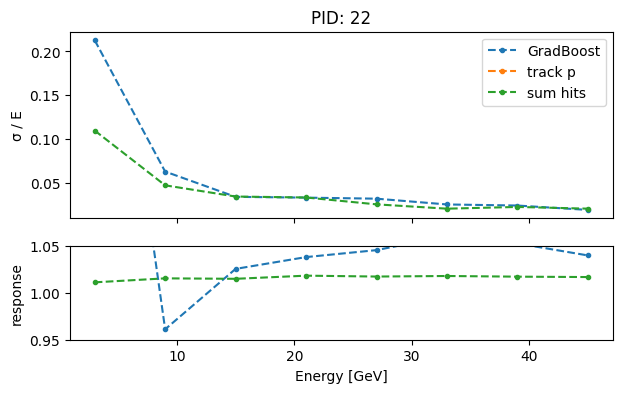

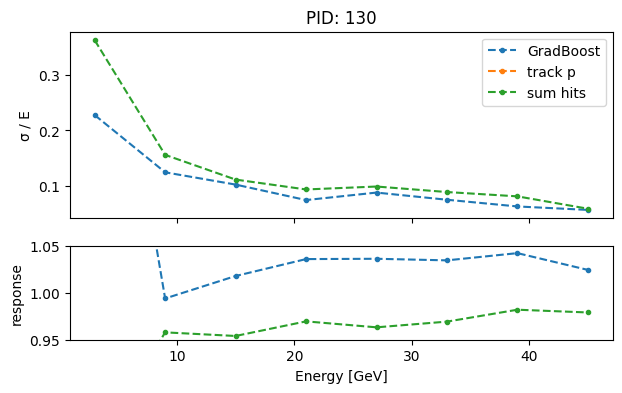

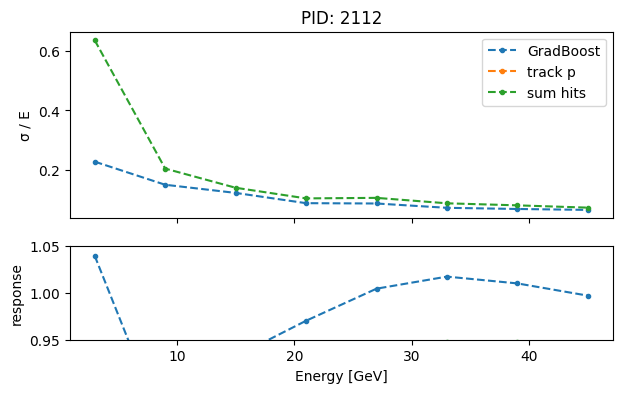

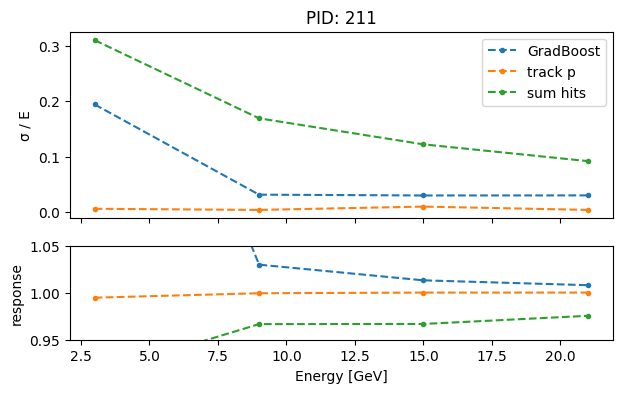

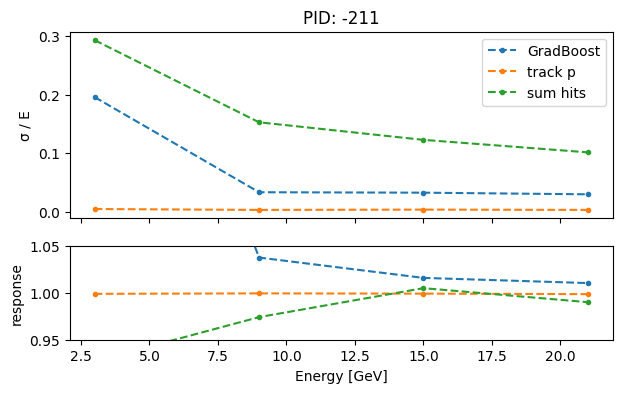

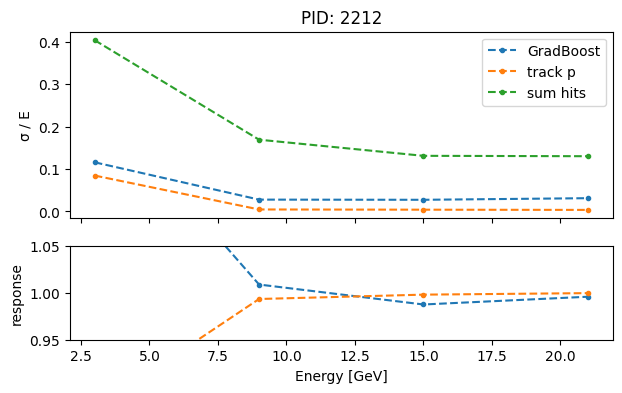

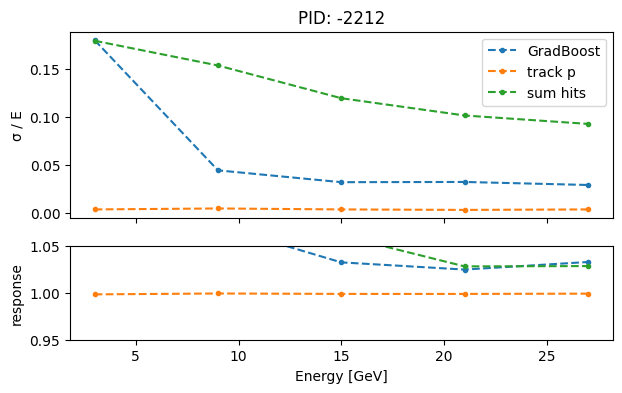

In [14]:
plots_all = get_plots([22, 130, 2112, 211, -211, 2212, -2212], energy_regression=True)

getting mask
got mask
Mask covers this fraction: 0.07897736132144928
Fitting


Loss: 179.484 / running loss: 52.894:  14%|█▎        | 1060/7831 [00:02<00:17, 390.32it/s]

Frozen batchnorm in layer BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Frozen batchnorm in layer BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Loss: 38.452 / running loss: 3.019: 100%|██████████| 7831/7831 [00:19<00:00, 391.90it/s]  


Epoch: 0 Loss: 38.452144622802734


Loss: 5.304 / running loss: 2.832:  14%|█▎        | 1064/7831 [00:03<00:20, 326.85it/s] 

Frozen batchnorm in layer BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Frozen batchnorm in layer BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Loss: 0.858 / running loss: 1.416:  14%|█▎        | 1067/7831 [00:03<00:20, 325.28it/s] 

Frozen batchnorm in layer BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Frozen batchnorm in layer BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Loss: 0.759 / running loss: 0.971:  13%|█▎        | 1041/7831 [00:02<00:18, 373.57it/s] 

Frozen batchnorm in layer BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Frozen batchnorm in layer BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Loss: 0.449 / running loss: 0.819:  14%|█▎        | 1064/7831 [00:03<00:19, 351.34it/s] 

Frozen batchnorm in layer BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Frozen batchnorm in layer BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Loss: 0.302 / running loss: 0.663:  14%|█▎        | 1058/7831 [00:03<00:19, 347.37it/s] 

Frozen batchnorm in layer BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Frozen batchnorm in layer BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Loss: 0.146 / running loss: 0.7:  14%|█▎        | 1070/7831 [00:03<00:18, 366.07it/s]   

Frozen batchnorm in layer BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Frozen batchnorm in layer BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Loss: 1.144 / running loss: 0.567:  14%|█▎        | 1060/7831 [00:02<00:15, 429.51it/s] 

Frozen batchnorm in layer BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Frozen batchnorm in layer BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Loss: 0.179 / running loss: 0.514:  13%|█▎        | 1040/7831 [00:03<00:19, 355.91it/s] 

Frozen batchnorm in layer BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Frozen batchnorm in layer BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Loss: 0.542 / running loss: 0.469:  13%|█▎        | 1050/7831 [00:02<00:19, 346.56it/s] 

Frozen batchnorm in layer BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Frozen batchnorm in layer BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Loss: 0.051 / running loss: 0.406:  60%|█████▉    | 4697/7831 [00:13<00:09, 341.61it/s] 


Early stopping at running mean loss: 0.406129700392019
Fitted model: None


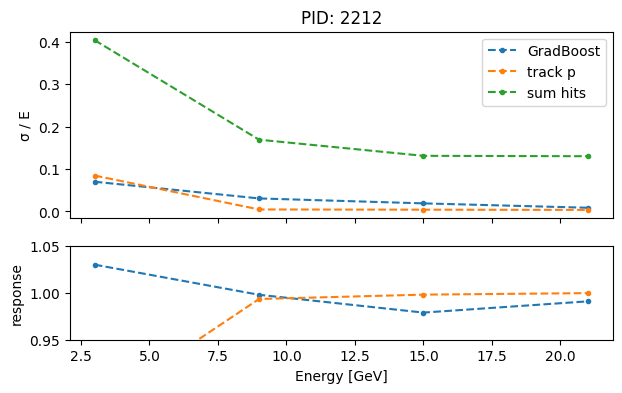

In [26]:
plots_p = get_plots([2212], energy_regression=True, patience=15000)

In [ ]:

plots_p = get_plots([2212], energy_regression=True, patience=15000)



In [ ]:

res_cf_regress_both = get_plots([211, -211, 2212, -2212], energy_regression=False, neutral=False)
res_energy_regress_both = get_plots([211, -211, 2212, -2212], energy_regression=True, neutral=False)
#res_cf_regress_NN_both = get_plots([211, -211, 2212, -2212], energy_regression=False, use_model="nn", neutral=False)


In [ ]:
_pid = 2212
res_cf_regress_p = get_plots([_pid], energy_regression=False)[_pid]
res_energy_regress_p = get_plots([_pid], energy_regression=True)[_pid]
#res_cf_regress_NN_p = get_plots([_pid], energy_regression=False, use_model="nn")[_pid]
#res_energy_regress_NN_p = get_plots([_pid], energy_regression=True, use_model="nn")[_pid]

In [10]:
# using gradboost1
#res_energy_regress_piplus_gb1 = get_plots([211], energy_regression=True, use_model="gradboost1")[211]


In [ ]:
res_cf_regress = get_plots([211], energy_regression=False, use_model="gradboost")[211]
res_energy_regress = get_plots([211], energy_regression=True, use_model="gradboost")[211]
###  res_cf_regress_NN = get_plots([211], energy_regression=False, use_model="nn")[211]

In [22]:
get_split(ds)[6].shape

torch.Size([99155])

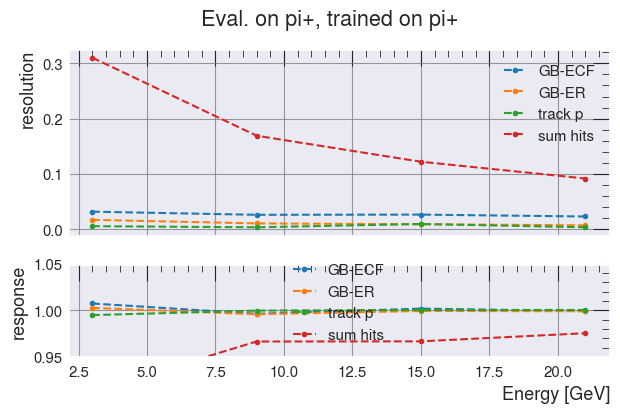

In [68]:

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress[2]
upper_curve_cf = res_cf_regress[0]["ML"]
upper_curve_energy = res_energy_regress[0]["ML"]
upper_curve_pandora  = res_energy_regress[0]["p"]
upper_curve_sum_hits = res_energy_regress[0]["sum"]
response_cf = res_cf_regress[1]["ML"]
response_energy = res_energy_regress[1]["ML"]
response_pandora = res_energy_regress[1]["p"]
response_sumhits = res_energy_regress[1]["sum"]


ax[0].plot(bins_x, upper_curve_cf, ".--", label="GB-ECF")
ax[0].plot(bins_x, upper_curve_energy, ".--", label="GB-ER")
ax[0].plot(bins_x, upper_curve_pandora, ".--", label="track p")
ax[0].plot(bins_x, upper_curve_sum_hits, ".--", label="sum hits")
ax[0].legend()
ax[0].set_ylabel("resolution")
ax[1].plot(bins_x, response_cf, ".--", label="GB-ECF")
ax[1].set_xlabel("Energy [GeV]")
ax[1].plot(bins_x, response_energy, ".--", label="GB-ER")
ax[1].plot(bins_x, response_pandora, ".--", label="track p")
ax[1].plot(bins_x, response_sumhits, ".--", label="sum hits")

ax[0].legend()
ax[1].legend()
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
#ax[1].legend()
# add grid
ax[0].grid(which='major', color='gray', linestyle='-')
ax[1].grid(which='major', color='gray', linestyle='-')

fig.suptitle("Eval. on pi+, trained on pi+")
fig.savefig("/eos/home-g/gkrzmanc/2024/21_3_xgboost/piplus_different_options.pdf")
fig.show()

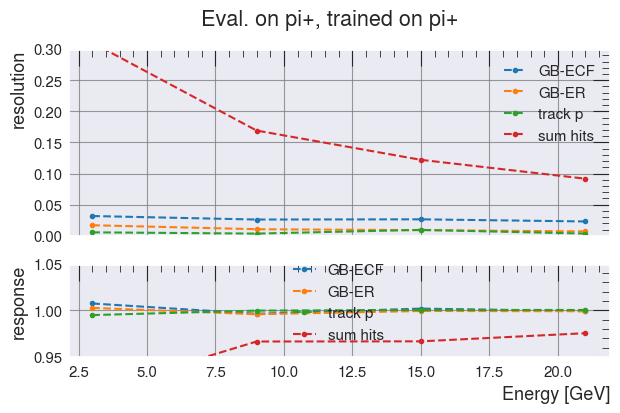

In [67]:

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress[2]
upper_curve_cf = res_cf_regress[0]["ML"]
upper_curve_energy = res_energy_regress[0]["ML"]
upper_curve_pandora  = res_energy_regress[0]["p"]
upper_curve_sum_hits = res_energy_regress[0]["sum"]
response_cf = res_cf_regress[1]["ML"]
response_energy = res_energy_regress[1]["ML"]
response_pandora = res_energy_regress[1]["p"]
response_sumhits = res_energy_regress[1]["sum"]

#upper_curve_gb1 = res_energy_regress_piplus_gb1[0]["ML"]
#response_gb1 = res_energy_regress_piplus_gb1[1]["ML"]


ax[0].plot(bins_x, upper_curve_cf, ".--", label="GB-ECF")
#ax[0].plot(bins_x, res_cf_regress_NN[0]["ML"], ".--", label="NN-ECF")
ax[0].plot(bins_x, upper_curve_energy, ".--", label="GB-ER")
ax[0].plot(bins_x, upper_curve_pandora, ".--", label="track p")
ax[0].plot(bins_x, upper_curve_sum_hits, ".--", label="sum hits")
ax[0].legend()
ax[0].set_ylabel("resolution")
ax[1].plot(bins_x, response_cf, ".--", label="GB-ECF")
ax[1].set_xlabel("Energy [GeV]")
#ax[1].plot(bins_x, res_cf_regress_NN[1]["ML"], ".--", label="NN-ECF")
ax[1].plot(bins_x, response_energy, ".--", label="GB-ER")
ax[1].plot(bins_x, response_pandora, ".--", label="track p")
ax[1].plot(bins_x, response_sumhits, ".--", label="sum hits")
#ax[0].plot(bins_x, res_energy_regress_NN[0]["ML"], ".--", label="NN-ER")
#ax[1].plot(bins_x, res_energy_regress_NN[1]["ML"], ".--", label="NN-ER")
ax[0].legend()
ax[1].legend()
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
ax[0].set_ylim([0, 0.3])
#ax[1].legend()
# add grid
ax[0].grid(which='major', color='gray', linestyle='-')
ax[1].grid(which='major', color='gray', linestyle='-')

fig.suptitle("Eval. on pi+, trained on pi+")
#fig.savefig("/eos/home-g/gkrzmanc/2024/21_3_/response_and_resolution_pi_plus_With_GB1.pdf")
fig.show()

In [73]:
upper_curve_energy

array([0.01150575, 0.008004  , 0.00650325, 0.0050025 , 0.00450225,
       0.00400601, 0.005997  , 0.00550275])

In [13]:
res_energy_regress[1].keys()

dict_keys(['ML', 'p', 'sumhits'])

In [9]:
neutrals = {
    "gamma": 22,
    "Klong": 130,
    "n": 2112
}
charged = {
    "pi+": 211,
    "pi-": -211,
    "p": 2212,
    "pbar": -2212,
    "e": 11
}


In [0]:
for key in neutrals:
    fig = get_neutral_response_resolution_plot_for_PID(neutrals[key])
    fig.suptitle(key)
    fig.savefig(f"/eos/user/g/gkrzmanc/2024/24_3_/response_and_resolution_plots_smooth_mean_{key}.pdf")
    fig.show()

In [0]:
for key in charged:
    fig = get_charged_response_resol_plot_for_PID(charged[key])
    fig.suptitle(key)
    fig.savefig(f"/eos/user/g/gkrzmanc/2024/24_3_/response_and_resolution_tracks_smooth_mean_{key}.pdf")
    fig.show()


Model: gradboost
Set model
getting mask
got mask
Mask covers this fraction: 0.5096767544746399
Fitting


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:01:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fitted model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:01:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Model: gradboost
Set model
getting mask
got mask
Mask covers this fraction: 0.5096767544746399
Fitting


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:01:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fitted model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:01:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


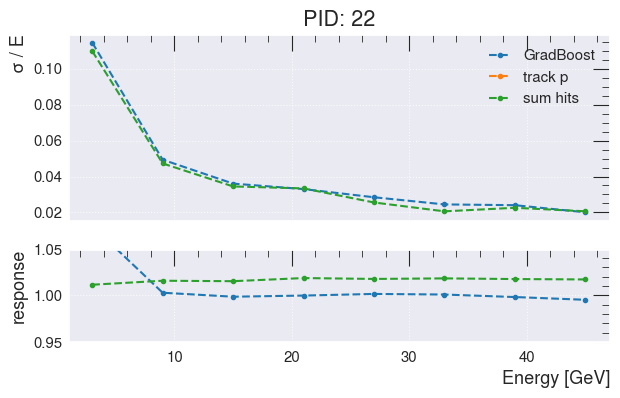

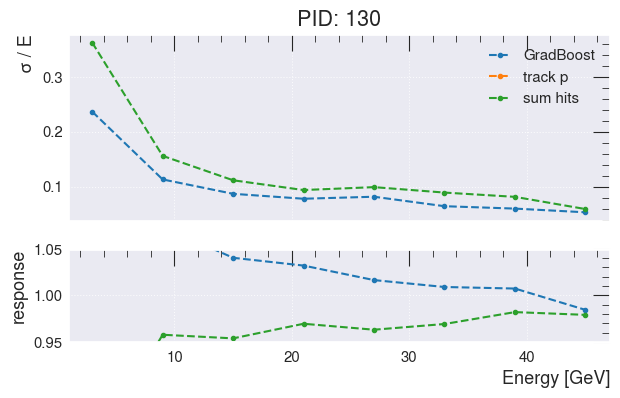

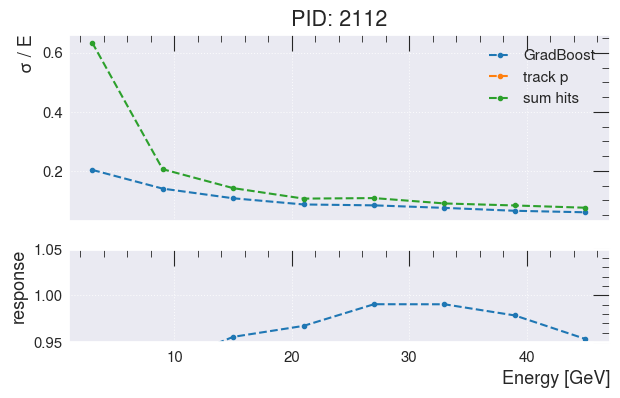

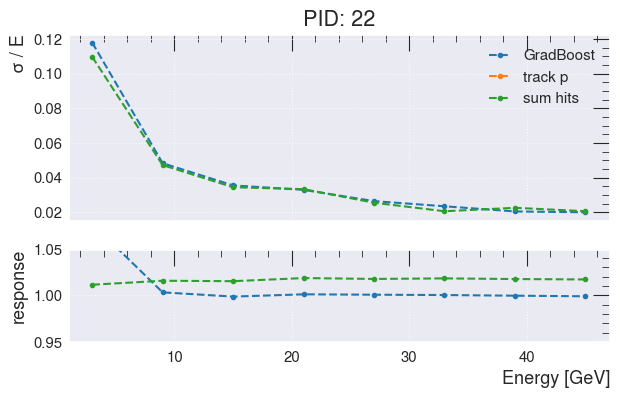

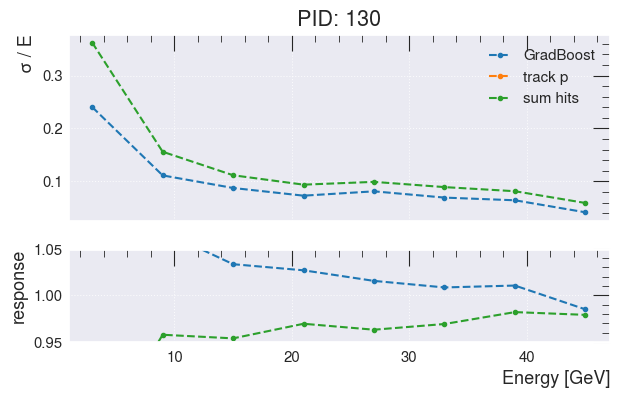

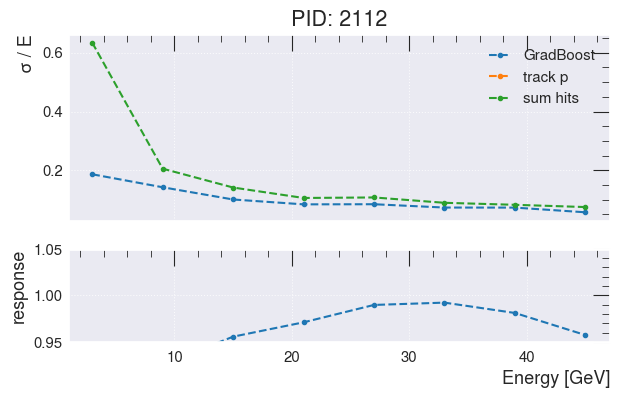

In [69]:
res_cf_regress_both_Neutral = get_plots([22, 130, 2112], energy_regression=False, neutral=True)
res_energy_regress_both_Neutral = get_plots([22, 130, 2112], energy_regression=True, neutral=True)
#res_cf_regress_NN_both_Neutral = get_plots([22, 130, 2112], energy_regression=False, use_model="nn", neutral=True)


In [ ]:
res_cf_regress_pi_klong = get_plots([211, 130], energy_regression=False, neutral=True)
res_energy_regress_pi_klong = get_plots([211, 130], energy_regression=True, neutral=True)
energy_regression_all_part = get_plots([22, 130, 2112, 211, -211, 2212, -2212], energy_regression=True)  # # No electrons for now! # #
energy_regression_all_charged_part = get_plots([211, -211, 2212, -2212], energy_regression=True, neutral=False)  # # No electrons for now! # #

Model: gradboost
Set model
getting mask
got mask
Mask covers this fraction: 0.16495385766029358
Fitting


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:02:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fitted model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:02:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Model: gradboost
Set model
getting mask
got mask
Mask covers this fraction: 0.16495385766029358
Fitting


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:02:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fitted model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:02:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


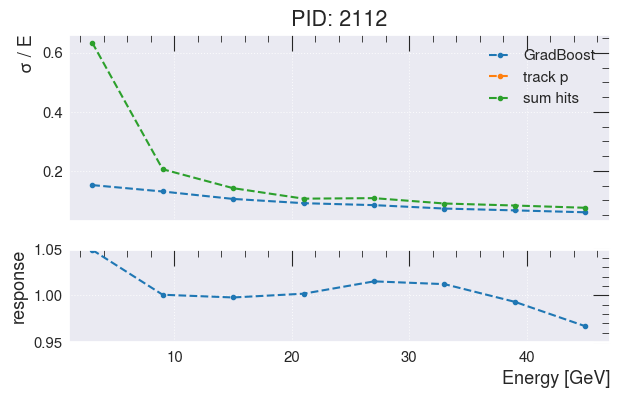

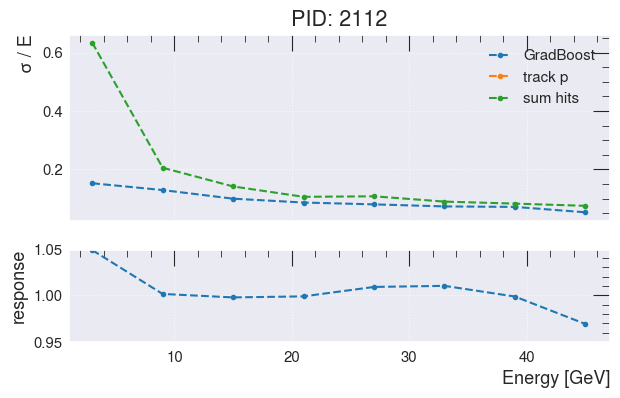

In [70]:
_pid = 2112
res_cf_regress_neutron = get_plots([_pid], energy_regression=False, neutral=True)[_pid]
res_energy_regress_neutron = get_plots([_pid], energy_regression=True, neutral=True)[_pid]
#res_cf_regress_NN_neutron = get_plots([_pid], energy_regression=False, use_model="nn", neutral=True)[_pid]


Model: gradboost
Set model
getting mask
got mask
Mask covers this fraction: 0.17118652164936066
Fitting


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:02:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fitted model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:03:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Model: gradboost
Set model
getting mask
got mask
Mask covers this fraction: 0.17118652164936066
Fitting


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:03:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fitted model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)


/home/gkrzmanc/env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:03:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


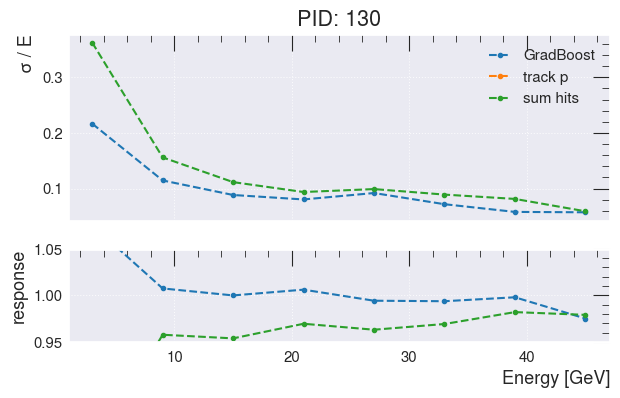

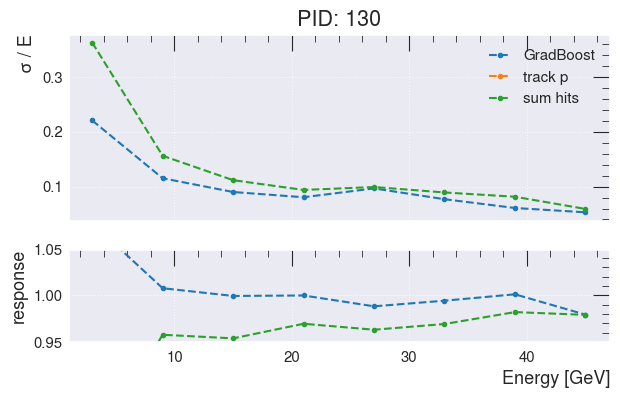

In [71]:
res_cf_regress_Klong = get_plots([130], energy_regression=False, neutral=True)[130]
res_energy_regress_Klong = get_plots([130], energy_regression=True, neutral=True)[130]
#res_cf_regress_NN_Klong = get_plots([130], energy_regression=False, use_model="nn", neutral=True)[130]


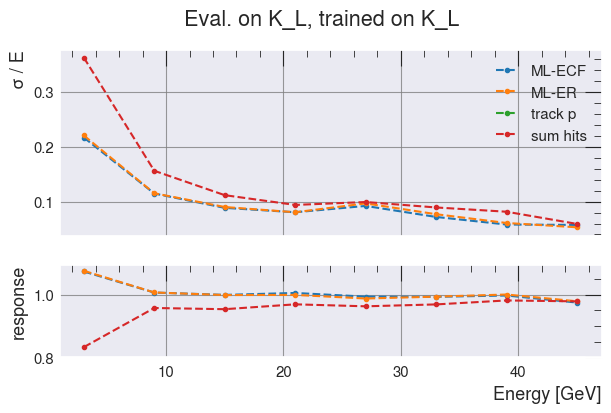

In [75]:

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress_Klong[2]
upper_curve_cf = res_cf_regress_Klong[0]["ML"]
upper_curve_energy = res_energy_regress_Klong[0]["ML"]
upper_curve_pandora  = res_energy_regress_Klong[0]["p"]
upper_curve_sum_hits = res_energy_regress_Klong[0]["sum"]
response_cf = res_cf_regress_Klong[1]["ML"]
response_energy = res_energy_regress_Klong[1]["ML"]
response_pandora = res_energy_regress_Klong[1]["p"]
response_sumhits = res_energy_regress_Klong[1]["sum"]

ax[0].plot(bins_x, upper_curve_cf, ".--", label="ML-ECF")
#ax[0].plot(bins_x, res_cf_regress_NN_Klong[0]["ML"], ".--", label="NN-ECF")
ax[0].plot(bins_x, upper_curve_energy, ".--", label="ML-ER")
ax[0].plot(bins_x, upper_curve_pandora, ".--", label="track p")
ax[0].plot(bins_x, upper_curve_sum_hits, ".--", label="sum hits")
ax[0].legend()
ax[0].set_ylabel("σ / E")
ax[1].plot(bins_x, response_cf, ".--", label="ML-ECF")
ax[1].set_xlabel("Energy [GeV]")
#ax[1].plot(bins_x, res_cf_regress_NN_Klong[1]["ML"], ".--", label="NN-ECF")
ax[1].plot(bins_x, response_energy, ".--", label="ML-ER")
ax[1].plot(bins_x, response_pandora, ".--", label="track p")
ax[1].plot(bins_x, response_sumhits, ".--", label="sum hits")
ax[1].set_ylim([0.8, 1.1])
#ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
#ax[1].legend()
ax[0].grid(which='major', color='gray', linestyle='-')
ax[1].grid(which='major', color='gray', linestyle='-')
fig.suptitle("Eval. on K_L, trained on K_L")
fig.savefig("/eos/home-g/gkrzmanc/2024/21_3_xgboost/K_long.pdf")
fig.show()


KeyError: 130

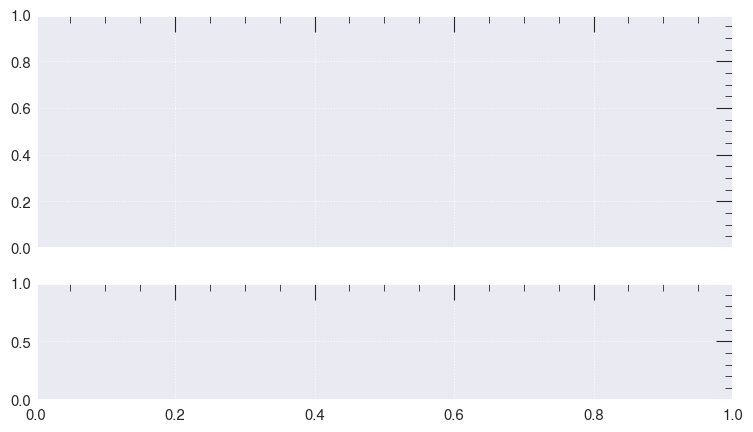

In [17]:

fig, ax = plt.subplots(2, 1, figsize=(9, 5), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress_Klong[2]

ax[0].plot(bins_x, res_cf_regress_both[130][0]["ML"], ".--", label="ML-CF-train pi+,Klong")
ax[0].plot(bins_x, res_energy_regress_both[130][0]["ML"], ".--", label="ML-ER-train pi+,Klong")

ax[0].plot(bins_x, res_cf_regress_Klong[0]["ML"], ".--", label="ML-CF-train Klong")
ax[0].plot(bins_x, res_energy_regress_Klong[0]["ML"], ".--", label="ML-ER-train Klong")

ax[0].legend()
ax[0].set_ylabel("σ / E")
ax[1].set_xlabel("Energy [GeV]")

ax[1].plot(bins_x, res_cf_regress_both[130][1]["ML"], ".--", label="ML-CF-train pi+,Klong")
ax[1].plot(bins_x, res_energy_regress_both[130][1]["ML"], ".--", label="ML-ER-train pi+,Klong")

ax[1].plot(bins_x, res_cf_regress_Klong[1]["ML"], ".--", label="ML-CF-train Klong")
ax[1].plot(bins_x, res_energy_regress_Klong[1]["ML"], ".--", label="ML-ER-train Klong")

ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
ax[1].legend()

fig.suptitle("Eval. on K_L, trained on pi+, K_L")
fig.show()

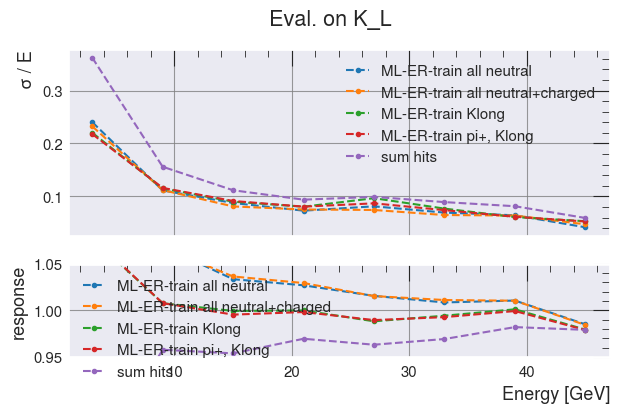

In [93]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress_Klong[2]

ax[0].plot(bins_x, res_energy_regress_both_Neutral[130][0]["ML"], ".--", label="ML-ER-train all neutral")
ax[0].plot(bins_x, energy_regression_all_part[130][0]["ML"], ".--", label="ML-ER-train all neutral+charged")
ax[0].plot(bins_x, res_energy_regress_Klong[0]["ML"], ".--", label="ML-ER-train Klong")
ax[0].plot(bins_x, res_energy_regress_pi_klong[130][0]["ML"], ".--", label="ML-ER-train pi+, Klong")
ax[0].plot(bins_x, res_energy_regress_Klong[0]["sum"], ".--", label="sum hits")

# add sum of hits for comparison
#ax[0].plot(bins_x, res_energy_regress_Klong[0]["sum"], ".--", label="sum hits")
ax[0].legend()
ax[0].set_ylabel("σ / E")
ax[1].set_xlabel("Energy [GeV]")
ax[1].plot(bins_x, res_energy_regress_both_Neutral[130][1]["ML"], ".--", label="ML-ER-train all neutral")
ax[1].plot(bins_x, energy_regression_all_part[130][1]["ML"], ".--", label="ML-ER-train all neutral+charged")
ax[1].plot(bins_x, res_energy_regress_Klong[1]["ML"], ".--", label="ML-ER-train Klong")
ax[1].plot(bins_x, res_energy_regress_pi_klong[130][1]["ML"], ".--", label="ML-ER-train pi+, Klong")
ax[1].plot(bins_x, res_energy_regress_Klong[1]["sum"], ".--", label="sum hits")
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
# add grid
ax[0].grid(which='major', color='gray', linestyle='-')
ax[1].grid(which='major', color='gray', linestyle='-')
# grid is not visible (dark mode) - how to change? 
ax[1].legend()
fig.suptitle("Eval. on K_L")
fig.savefig("/eos/home-g/gkrzmanc/2024/21_3_xgboost/response_and_resolution_Klong.pdf")
fig.show()



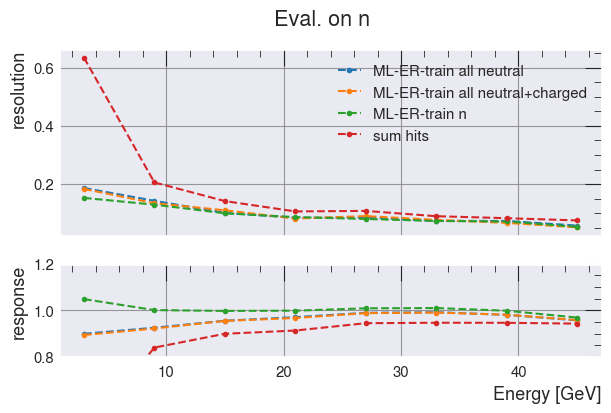

In [85]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress_Klong[2]

ax[0].plot(bins_x, res_energy_regress_both_Neutral[2112][0]["ML"], ".--", label="ML-ER-train all neutral")
ax[0].plot(bins_x, energy_regression_all_part[2112][0]["ML"], ".--", label="ML-ER-train all neutral+charged")

ax[0].plot(bins_x, res_energy_regress_neutron[0]["ML"], ".--", label="ML-ER-train n")
# add sum of hits for comparison
ax[0].plot(bins_x, res_energy_regress_neutron[0]["sum"], ".--", label="sum hits")
ax[0].legend()
ax[0].set_ylabel("resolution")
ax[1].set_xlabel("Energy [GeV]")
ax[1].plot(bins_x, res_energy_regress_both_Neutral[2112][1]["ML"], ".--", label="ML-ER-train all")
ax[1].plot(bins_x, energy_regression_all_part[2112][1]["ML"], ".--", label="ML-ER-train all")
ax[1].plot(bins_x, res_energy_regress_neutron[1]["ML"], ".--", label="ML-ER-train n")
ax[1].plot(bins_x, res_energy_regress_neutron[1]["sum"], ".--", label="sum hits")
ax[1].set_ylim([0.8, 1.2])
ax[1].set_ylabel("response")
ax[0].grid(which='major', color='gray', linestyle='-')
ax[1].grid(which='major', color='gray', linestyle='-')
#ax[1].legend()
fig.suptitle("Eval. on n")
fig.savefig("/eos/home-g/gkrzmanc/2024/21_3_xgboost/response_and_resolution_neutrons.pdf")
fig.show()

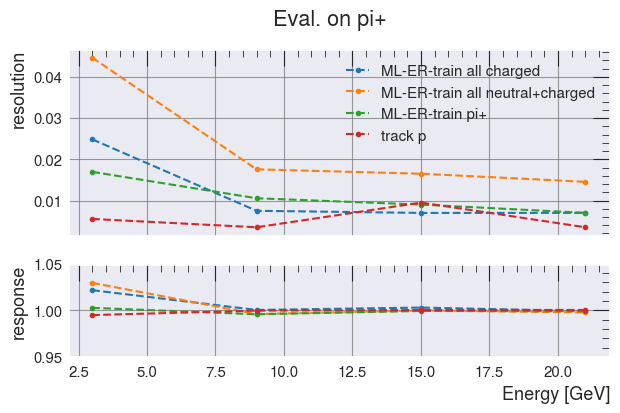

In [87]:

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress_Klong[2]

ax[0].plot(bins_x, res_energy_regress_both[211][0]["ML"], ".--", label="ML-ER-train all charged")
ax[0].plot(bins_x, energy_regression_all_part[211][0]["ML"], ".--", label="ML-ER-train all neutral+charged")
ax[0].plot(bins_x, res_energy_regress[0]["ML"], ".--", label="ML-ER-train pi+")
# plot also the track baseline
ax[0].plot(bins_x, res_energy_regress[0]["p"], ".--", label="track p")

ax[0].legend()
ax[0].set_ylabel("resolution")
ax[1].set_xlabel("Energy [GeV]")
ax[1].plot(bins_x, res_cf_regress_both[211][1]["ML"], ".--", label="ML-ER-train all charged")
ax[1].plot(bins_x, energy_regression_all_part[211][1]["ML"], ".--", label="ML-ER-train all neutral+charged")
ax[1].plot(bins_x, res_energy_regress[1]["ML"], ".--", label="ML-ER-train pi+")
ax[1].plot(bins_x, res_energy_regress[1]["p"], ".--", label="track p")
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
ax[0].grid(which='major', color='gray', linestyle='-')
ax[1].grid(which='major', color='gray', linestyle='-')
fig.suptitle("Eval. on pi+")
fig.savefig("/eos/home-g/gkrzmanc/2024/19_3_/response_and_resolution_pi_plus.pdf")
fig.show()

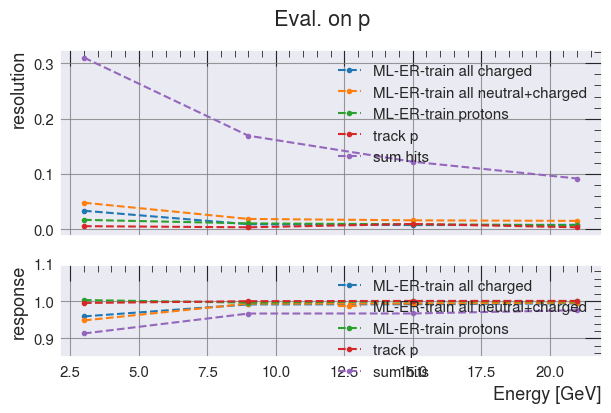

In [89]:

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress_Klong[2]

ax[0].plot(bins_x, res_energy_regress_both[2212][0]["ML"], ".--", label="ML-ER-train all charged")
ax[0].plot(bins_x, energy_regression_all_part[2212][0]["ML"], ".--", label="ML-ER-train all neutral+charged")
ax[0].plot(bins_x, res_energy_regress[0]["ML"], ".--", label="ML-ER-train protons")
# plot also the track baseline
ax[0].plot(bins_x, res_energy_regress[0]["p"], ".--", label="track p")
ax[0].plot(bins_x, res_energy_regress[0]["sum"], ".--", label="sum hits")
ax[0].legend()
ax[0].set_ylabel("resolution")
ax[1].set_xlabel("Energy [GeV]")
ax[1].plot(bins_x, res_cf_regress_both[2212][1]["ML"], ".--", label="ML-ER-train all charged")
ax[1].plot(bins_x, energy_regression_all_part[2212][1]["ML"], ".--", label="ML-ER-train all neutral+charged")
ax[1].plot(bins_x, res_energy_regress[1]["ML"], ".--", label="ML-ER-train protons")
ax[1].plot(bins_x, res_energy_regress[1]["p"], ".--", label="track p")
ax[1].plot(bins_x, res_energy_regress[1]["sum"], ".--", label="sum hits")
ax[1].set_ylim([0.85, 1.1])
ax[1].set_ylabel("response")
ax[0].grid(which='major', color='gray', linestyle='-')
ax[1].grid(which='major', color='gray', linestyle='-')
ax[1].legend()
fig.suptitle("Eval. on p")
fig.savefig("/eos/home-g/gkrzmanc/2024/21_3_xgboost/response_and_resolution_protons.pdf")
fig.show()


In [52]:
 ## There is around 8% pi+ in dataset - try to downsample the "full" dataset to this fraction and see if the results are similar.


ModuleNotFoundError: No module named 'CatBoost'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


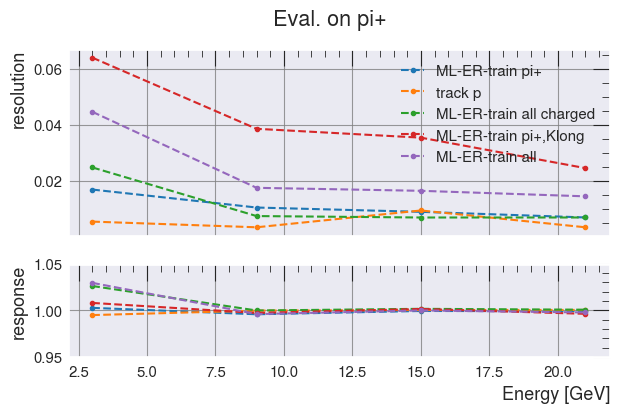

In [96]:

# energy_regression_all_part, res_energy_regress_pi_klong,  # res_energy_regress[0]["ML"]
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress_Klong[2]

# plot the pions
ax[0].plot(bins_x, res_energy_regress[0]["ML"], ".--", label="ML-ER-train pi+")
ax[0].plot(bins_x, res_energy_regress[0]["p"], ".--", label="track p")
ax[0].plot(bins_x, res_energy_regress_both[211][0]["ML"], ".--", label="ML-ER-train all charged")
ax[0].plot(bins_x, res_energy_regress_pi_klong[211][0]["ML"], ".--", label="ML-ER-train pi+,Klong")
ax[0].plot(bins_x, energy_regression_all_part[211][0]["ML"], ".--", label="ML-ER-train all")
#ax[0].plot(bins_x, res_energy_regress_both[211][0]["sum"], ".--", label="sum hits")

ax[0].legend()
ax[1].legend()
ax[1].plot(bins_x, res_energy_regress[1]["ML"], ".--", label="ML-ER-train pi+")
ax[1].plot(bins_x, res_energy_regress[1]["p"], ".--", label="track p")
ax[1].plot(bins_x, res_energy_regress_both[211][1]["ML"], ".--", label="ML-ER-train all charged")
ax[1].plot(bins_x, res_energy_regress_pi_klong[211][1]["ML"], ".--", label="ML-ER-train pi+,Klong")
ax[1].plot(bins_x, energy_regression_all_part[211][1]["ML"], ".--", label="ML-ER-train all")
#ax[1].plot(bins_x, res_energy_regress_both[211][1]["sum"], ".--", label="sum hits")
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylim([0.95, 1.05])


ax[1].set_ylabel("response")

ax[0].grid(which='major', color='gray', linestyle='-')
ax[1].grid(which='major', color='gray', linestyle='-')


ax[0].set_ylabel("resolution")
ax[1].set_xlabel("Energy [GeV]")
ax[1].set_ylim([0.95, 1.05])
ax[0].legend()

fig.suptitle("Eval. on pi+")
fig.savefig("/eos/home-g/gkrzmanc/2024/21_3_xgboost/response_and_resolution_pi_plus_full_with_charged.pdf")
fig.show()
